<a href="https://colab.research.google.com/github/shreyus3003/CMPE297_sec49/blob/master/Assignment_4/Multi_Task_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  # Multitask learning 

  In this eaxmple of multitask learning, we try to boost the siamese network.
  the objects are compared in new embedding space, similar objects are to be close together and different objects apart. We are trying to embed the MNIST images in some vector space. These networks has 2 input layers and the weights are shared between the input layers. We shall see how adding an aditional loss to these layers will improve the accuracy.

In [22]:
import numpy as np

import random
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
from keras.optimizers import RMSprop
from keras import backend as K
from keras.utils import to_categorical

num_classes = 10

In [23]:
random.seed(42)
np.random.seed(42)

## Define the loss function.

In [47]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
  
    margin = 1
    sqaure_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * sqaure_pred + (1 - y_true) * margin_square)


def create_pairs_multitask(x, digit_indices):
   
    pairs = []
    labels = []
    class_1, class_2 = [], []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]] 
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes 
            z1, z2 = digit_indices[d][i], digit_indices[dn][i] 
            pairs += [[x[z1], x[z2]]] 
            labels += [1, 0] 
            class_1 += [d, d]
            class_2 += [d, dn]
    return np.array(pairs), np.array(labels), np.array(class_1), np.array(class_2)

##Create a base network

In [62]:
def create_base_network(input_shape):
    
    print(input_shape)
    input = Input(shape=input_shape)
    print(input.dtype)
    x = Flatten()(input)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.1)(x)
    print(x.dtype)
    return Model(input, x)


def compute_accuracy(y_true, y_pred):
    
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

## Load the MNIST data 

In [69]:

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
x_train /= 255
x_test /= 255
input_shape = x_train.shape[1:]


digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y, tr_c1, tr_c2 = create_pairs_multitask(x_train, digit_indices)
tr_y = tr_y.astype(np.float32)

digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y, te_c1, te_c2 = create_pairs_multitask(x_test, digit_indices)
te_y = te_y.astype(np.float32)

tr_c1, tr_c2 = to_categorical(tr_c1), to_categorical(tr_c2)
te_c1, te_c2 = to_categorical(te_c1), to_categorical(te_c2)

## Define a network without aditional loss 

In [78]:
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

(28, 28)
<dtype: 'float32'>
<dtype: 'float32'>


In [79]:
model.summary()

Model: "functional_43"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_34 (InputLayer)           [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
input_35 (InputLayer)           [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
functional_41 (Functional)      (None, 64)           50240       input_34[0][0]                   
                                                                 input_35[0][0]                   
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None, 1)            0           functional_41[0][0]  

In [80]:
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms)
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=10,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

Epoch 1/10
847/847 [==============================] - 3s 3ms/step - loss: 0.1819 - val_loss: 0.1239
Epoch 2/10
847/847 [==============================] - 2s 3ms/step - loss: 0.1512 - val_loss: 0.1117
Epoch 3/10
847/847 [==============================] - 2s 3ms/step - loss: 0.1466 - val_loss: 0.1040
Epoch 4/10
847/847 [==============================] - 2s 3ms/step - loss: 0.1458 - val_loss: 0.1070
Epoch 5/10
847/847 [==============================] - 2s 3ms/step - loss: 0.1446 - val_loss: 0.1007
Epoch 6/10
847/847 [==============================] - 2s 3ms/step - loss: 0.1439 - val_loss: 0.1053
Epoch 7/10
847/847 [==============================] - 2s 3ms/step - loss: 0.1434 - val_loss: 0.1034
Epoch 8/10
847/847 [==============================] - 2s 3ms/step - loss: 0.1432 - val_loss: 0.1029
Epoch 9/10
847/847 [==============================] - 2s 3ms/step - loss: 0.1425 - val_loss: 0.1099
Epoch 10/10
847/847 [==============================] - 2s 3ms/step - loss: 0.1429 - val_loss: 0.1096

In [81]:
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

* Accuracy on training set: 87.06%
* Accuracy on test set: 86.98%


## Define the network with additional loss. multitasking 

In [71]:
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

class_1_out = Dense(num_classes, activation = 'softmax')(processed_a)
class_2_out = Dense(num_classes, activation = 'softmax')(processed_b)

model = Model([input_a, input_b], [distance, class_1_out, class_2_out])

(28, 28)
<dtype: 'float32'>
<dtype: 'float32'>


In [77]:
model.summary()

Model: "functional_39"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
input_32 (InputLayer)           [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
functional_37 (Functional)      (None, 64)           50240       input_31[0][0]                   
                                                                 input_32[0][0]                   
__________________________________________________________________________________________________
lambda_9 (Lambda)               (None, 1)            0           functional_37[0][0]  

In [72]:
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms)
hist = model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], [tr_y, tr_c1, tr_c2],
          batch_size=128,
          epochs=10,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], [te_y, te_c1, te_c2]))

Epoch 1/10
847/847 [==============================] - 5s 6ms/step - loss: 1.6374 - lambda_9_loss: 0.1859 - dense_16_loss: 0.7259 - dense_17_loss: 0.7257 - val_loss: 1.5755 - val_lambda_9_loss: 0.1303 - val_dense_16_loss: 0.7227 - val_dense_17_loss: 0.7225
Epoch 2/10
847/847 [==============================] - 4s 5ms/step - loss: 1.5929 - lambda_9_loss: 0.1516 - dense_16_loss: 0.7207 - dense_17_loss: 0.7205 - val_loss: 1.5480 - val_lambda_9_loss: 0.1107 - val_dense_16_loss: 0.7187 - val_dense_17_loss: 0.7186
Epoch 3/10
847/847 [==============================] - 4s 5ms/step - loss: 1.5855 - lambda_9_loss: 0.1482 - dense_16_loss: 0.7187 - dense_17_loss: 0.7186 - val_loss: 1.5378 - val_lambda_9_loss: 0.1037 - val_dense_16_loss: 0.7171 - val_dense_17_loss: 0.7170
Epoch 4/10
847/847 [==============================] - 4s 5ms/step - loss: 1.5813 - lambda_9_loss: 0.1457 - dense_16_loss: 0.7178 - dense_17_loss: 0.7177 - val_loss: 1.5387 - val_lambda_9_loss: 0.1061 - val_dense_16_loss: 0.7163 - va

In [73]:

y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])[0]
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])[0]
te_acc = compute_accuracy(te_y, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

* Accuracy on training set: 87.54%
* Accuracy on test set: 87.42%


When we compare the accuracy, we see that the network with additional loss gives good accuracy. 

In [75]:
import pylab
%matplotlib inline


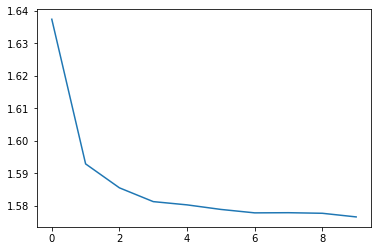

In [76]:
pylab.plot(hist.history['loss'])